In [26]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor as pt
import pybaseball 
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
#import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pt.config.exception_verbosity = 'high'

RANDOM_SEED = 504

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.19.1


In [2]:
from retrieve_sql_module import get_events_data
events_data_2024 = get_events_data("2024")

In [3]:
events_data_2024

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,field_error_n,sac_fly_n,n_pitches,total_events,single_rate,double_rate,triple_rate,home_run_rate,strikeout_rate,field_out_rate
0,None,2024-03-24,NaN,NaN,NaN,"Crawford, Kutter",669221,676710,field_out,field_out,...,4,1,1095,274,0.113139,0.018248,0.003650,0.113139,0.244526,0.463504
1,None,2024-03-24,NaN,NaN,NaN,"Crawford, Kutter",671739,676710,field_out,field_out,...,6,3,1729,489,0.179959,0.034765,0.006135,0.179959,0.196319,0.488753
2,None,2024-03-24,NaN,NaN,NaN,"Crawford, Kutter",542303,676710,field_out,field_out,...,1,5,2943,709,0.163611,0.043724,0.000000,0.163611,0.255289,0.368124
3,None,2024-03-24,NaN,NaN,NaN,"Crawford, Kutter",621566,676710,field_error,field_out,...,4,5,3023,702,0.118234,0.052707,0.001425,0.118234,0.253561,0.415954
4,None,2024-03-24,NaN,NaN,NaN,"Bummer, Aaron",641933,607481,field_out,field_out,...,3,2,2037,485,0.105155,0.039175,0.000000,0.105155,0.334021,0.329897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187277,None,2024-03-21,NaN,NaN,NaN,"Williams, Trevor",668791,592866,hit_by_pitch,ball,...,0,0,20,7,0.285714,0.142857,0.000000,0.285714,0.142857,0.285714
187278,None,2024-03-21,NaN,NaN,NaN,"Thornton, Trent",663697,663423,hit_by_pitch,ball,...,4,6,2679,652,0.141104,0.042945,0.003067,0.141104,0.194785,0.430982
187279,None,2024-03-20,NaN,NaN,NaN,"Webb, Jacob",642215,657097,hit_by_pitch,ball,...,1,1,394,103,0.135922,0.067961,0.009709,0.135922,0.281553,0.359223
187280,None,2024-03-20,NaN,NaN,NaN,"Cuas, Jose",676116,621016,hit_by_pitch,ball,...,0,0,542,125,0.080000,0.040000,0.000000,0.080000,0.320000,0.392000


In [4]:
events_data_2024["description"].unique()

array(['field_out', 'single', 'home_run', 'double', 'triple', 'foul',
       'swinging_strike', 'ball', 'called_strike'], dtype=object)

In [5]:
coords = {
    "category": events_data_2024["description"].unique().tolist(),
    "batter": events_data_2024["batter"].unique().tolist()
}

In [6]:
description, unique_categories = pd.factorize(events_data_2024["description"], sort = True)

In [11]:
unique_categories.tolist()

['ball',
 'called_strike',
 'double',
 'field_out',
 'foul',
 'home_run',
 'single',
 'swinging_strike',
 'triple']

In [10]:
events_data_2024["batter"].unique().tolist() 

[669221,
 671739,
 542303,
 621566,
 641933,
 666915,
 681377,
 600869,
 668715,
 663697,
 645801,
 605361,
 666181,
 593871,
 641487,
 663728,
 656413,
 682829,
 668942,
 670042,
 571745,
 669023,
 702332,
 621450,
 680672,
 687862,
 695312,
 685300,
 620443,
 695587,
 687248,
 663604,
 656185,
 672284,
 606115,
 663330,
 660670,
 665828,
 669224,
 683011,
 657077,
 669392,
 622569,
 645277,
 657136,
 646240,
 680776,
 663586,
 678882,
 671213,
 596115,
 807799,
 669336,
 660757,
 670351,
 672356,
 666310,
 664702,
 671221,
 687731,
 688457,
 657557,
 680837,
 670231,
 686475,
 686823,
 657656,
 647304,
 608070,
 665926,
 676369,
 679845,
 680757,
 607680,
 506702,
 686523,
 683734,
 673357,
 668472,
 624428,
 543592,
 660162,
 680769,
 643217,
 670032,
 687401,
 669471,
 680518,
 681987,
 606992,
 670712,
 663368,
 670092,
 657757,
 666183,
 656883,
 677578,
 682631,
 685133,
 622268,
 666149,
 682674,
 672275,
 682641,
 682617,
 665998,
 666023,
 680118,
 669003,
 694368,
 641658,
 

In [12]:
coords

{'category': ['ball',
  'called_strike',
  'double',
  'field_out',
  'foul',
  'home_run',
  'single',
  'swinging_strike',
  'triple'],
 'batter': [669221,
  671739,
  542303,
  621566,
  641933,
  666915,
  681377,
  600869,
  668715,
  663697,
  645801,
  605361,
  666181,
  593871,
  641487,
  663728,
  656413,
  682829,
  668942,
  670042,
  571745,
  669023,
  702332,
  621450,
  680672,
  687862,
  695312,
  685300,
  620443,
  695587,
  687248,
  663604,
  656185,
  672284,
  606115,
  663330,
  660670,
  665828,
  669224,
  683011,
  657077,
  669392,
  622569,
  645277,
  657136,
  646240,
  680776,
  663586,
  678882,
  671213,
  596115,
  807799,
  669336,
  660757,
  670351,
  672356,
  666310,
  664702,
  671221,
  687731,
  688457,
  657557,
  680837,
  670231,
  686475,
  686823,
  657656,
  647304,
  608070,
  665926,
  676369,
  679845,
  680757,
  607680,
  506702,
  686523,
  683734,
  673357,
  668472,
  624428,
  543592,
  660162,
  680769,
  643217,
  670032,
  

In [15]:
print(description.shape)

(187282,)


In [20]:
coords =  {
    "category" : unique_categories.tolist(),
    "batter" : events_data_2024["batter"].unique().tolist(),
    "pitch": np.arange(187282)
}

In [21]:
print(coords)

{'category': ['ball', 'called_strike', 'double', 'field_out', 'foul', 'home_run', 'single', 'swinging_strike', 'triple'], 'batter': [669221, 671739, 542303, 621566, 641933, 666915, 681377, 600869, 668715, 663697, 645801, 605361, 666181, 593871, 641487, 663728, 656413, 682829, 668942, 670042, 571745, 669023, 702332, 621450, 680672, 687862, 695312, 685300, 620443, 695587, 687248, 663604, 656185, 672284, 606115, 663330, 660670, 665828, 669224, 683011, 657077, 669392, 622569, 645277, 657136, 646240, 680776, 663586, 678882, 671213, 596115, 807799, 669336, 660757, 670351, 672356, 666310, 664702, 671221, 687731, 688457, 657557, 680837, 670231, 686475, 686823, 657656, 647304, 608070, 665926, 676369, 679845, 680757, 607680, 506702, 686523, 683734, 673357, 668472, 624428, 543592, 660162, 680769, 643217, 670032, 687401, 669471, 680518, 681987, 606992, 670712, 663368, 670092, 657757, 666183, 656883, 677578, 682631, 685133, 622268, 666149, 682674, 672275, 682641, 682617, 665998, 666023, 680118, 669

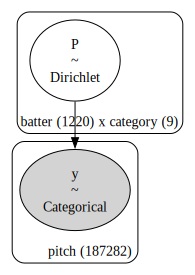

In [23]:
with pm.Model(coords=coords) as uninformative_prior_model:
    p = pm.Dirichlet("p", a=np.ones(len(coords["category"])), dims=('batter', 'category'))

    y = pm.Categorical("y", p = p, observed = description, dims = "pitch")
pm.model_to_graphviz(uninformative_prior_model)

In [33]:
batter_mapping = {b: i for i, b in enumerate(coords["batter"])}
batter_idx_numeric = np.array([batter_mapping[b] for b in events_data_2024["batter"]])

array([  0,   1,   2, ..., 519, 254, 611])

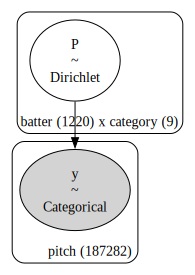

In [36]:
with pm.Model(coords=coords) as model:
    batter_idx = pm.Data("batter_idx", batter_idx_numeric, dims="pitch")
    p = pm.Dirichlet("p", a=np.ones((len(coords["batter"]), len(coords["category"]))), dims=('batter', 'category'))
    y = pm.Categorical("y", p=p[batter_idx], observed=description, dims="pitch")
pm.model_to_graphviz(uninformative_prior_model)

In [28]:
np.ones(len(coords["category"]))

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [38]:
with model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


In [39]:
uninformed_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [43]:
so.Plot(uninformed_prior_trace.prior['p'].sel(chain=[0], draw = [0]).squeeze()).add(so.Bars(), so.Hist(bins = 20))

ValueError: If using all scalar values, you must pass an index